## Packages and constant declaration

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131304 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
import time

In [0]:
import numpy as np  #linear algebra
import pandas as pd #Only CSV IO
import os
import re
from torch.utils import data #dataloader of batch
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from torch.autograd import Variable #We can ask require grad or not
from torch.optim.optimizer import Optimizer
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torchvision import transforms

Using TensorFlow backend.


In [0]:
import matplotlib.pyplot as plt

In [0]:
# !ls drive/'My Drive'/'Colab Notebooks'/project
# !ls
os.chdir("drive/My Drive/Colab Notebooks/project") 
!ls

 Cnn.ipynb    Project_cnn_2.0.ipynb    Project_raw.ipynb   train.csv
 embeddings  'Project_raw (2).ipynb'   test.csv


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
from sklearn.preprocessing import StandardScaler # Simplify the preprocess
from multiprocessing import pool #multiprocessing, creating a pool parallel
from functools import partial 
#freeze some arguments of a function to be a new function
from sklearn.decomposition import PCA


In [0]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # easy to locate traceback
embedding_size = 300 # embedding vector length
max_word = 200000 # How many unique words to use 
max_q = 60 # max number of words in a question
maxq=60
batch_size = 1024#Batch size
n_epochs = 23 # epochs

In [0]:
def seed(seed=1000):# Give random seed to everything
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed()

## Data preprocessing

In [0]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean(x): #process the punction
    x=str(x)
    for punct in puncts:
        if punct in x:
            x=x.replace(punct,f'{punct}')
    return x

def clean_numbers(x): # Replace the number with #, make all numbers the same
    if bool(re.search(r'\d',x)):
        x=re.sub('[0-9]{5,}','#####',x)
        x=re.sub('[0-9]{4}','####',x)
        x=re.sub('[0-9]{3}','###',x)
        x=re.sub('[0-9]{2}','##',x)
    return x

# The common abbreviation for some phrase
fullversiondict={"ain't": "is not", "aren't": "are not","can't": "cannot",
                 "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  
                 "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                 "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                 "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                 "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                 "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                 "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                 "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                 "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                 "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", 
                 "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have",
                 "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                 "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
                 "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
                 "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                 "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
                 "you're": "you are", "you've": "you have", 'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 
                 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do',
                 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018',
                 'qouta': 'quota','exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'}
def _get_full(fullversiondict):
    full_re = re.compile('(%s)'%'|'.join(fullversiondict.keys()))
    return fullversiondict , full_re # To make things we want to replace single string

fullversiondict,full_re=_get_full(fullversiondict)
def replacetext(text):
    def replace(match): 
        return fullversiondict[match.group(0)]
    return full_re.sub(replace,text) # The full.re here is match, can replace any string now


In [0]:
def read_pre():
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    print('Train shape:',train_df.shape)
    print('Test shape:',test_df.shape)
    # Lower case
    train_df['question_text'] = train_df['question_text'].apply(lambda x: x.lower())
    test_df['question_text'] = test_df['question_text'].apply(lambda x: x.lower())
    # Clean punction
    train_df["question_text"] = train_df["question_text"].apply(lambda x: clean(x))
    test_df["question_text"] = test_df["question_text"].apply(lambda x: clean(x))
    #clean numbers
    train_df["question_text"] = train_df["question_text"].apply(lambda x: clean_numbers(x))
    test_df["question_text"] = test_df["question_text"].apply(lambda x: clean_numbers(x))
    #replace abbreviation
    train_df["question_text"] = train_df["question_text"].apply(lambda x: replacetext(x))
    test_df["question_text"] = test_df["question_text"].apply(lambda x: replacetext(x))
    ## fill up the missing values using next valid value
    train_X = train_df["question_text"].fillna(method="bfill").values
    test_X = test_df["question_text"].fillna(method="bfill").values
    
    ####################
    #Tokenize the sentences
    tokenizer = Tokenizer(num_words = max_word)
    tokenizer.fit_on_texts(list(train_X)) # only use words in training set
    train_X = tokenizer.texts_to_sequences(train_X)
    test_X = tokenizer.texts_to_sequences(test_X)
    word_index = tokenizer.word_index
    nb_words = min(max_word, len(word_index))
        
    #Pad the sentences, to make equal length of sentences
    train_X = pad_sequences(train_X, maxlen=maxq)
    test_X = pad_sequences(test_X, maxlen=maxq)
     
    #Similar to one-hot encoding   
    #train_X=np.delete(train_X,[np.where(np.sum(train_X,axis=1)==0)])
    #test_X=np.delete(test_X,[np.where(np.sum(test_X,axis=1)==0)])
    
    #Target
    train_y = train_df['target'].values
    return train_X, test_X, train_y, word_index
    

In [0]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x
#Data augmentation

In [0]:
# the pretrained embedding model
def load_glove(word_index):
    FILE= 'embeddings/glove.840B.300d//glove.840B.300d.txt'
    def get_coefs(word,*arr):return word, np.asarray(arr, dtype='float32')[:embedding_size]
    embeddings_index = dict(get_coefs(*o.split(' '))for o in open(FILE) if len(o)>300)
    #construct word array pair dictionary
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    nb_words = min(max_word, len(word_index))
    #Initialize a matrix using random value, in case that some words don't exist in our embedding
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words+1,embedding_size))
    #Associate the word in our training set with the embedding model
    for word, i in word_index.items():
        if i>= max_word: continue
        embedding_vector = embeddings_index.get(word) # get the vector for this word form dictionary
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    return (embedding_matrix)
##Do same thing to other types of embedding

def load_para(word_index):
    FILE = 'embeddings/paragram_300_sl999-1/paragram_300_sl999.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(FILE, encoding="utf8", errors='ignore') if len(o)>300)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()

    nb_words = min(max_word, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words+1, embedding_size))
    for word, i in word_index.items():
        if i >= max_word: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    
    return embedding_matrix


In [0]:
train_X, test_X, train_y,  word_index = read_pre()
embedding_matrix_1 = load_glove(word_index)

Train shape: (1306122, 3)
Test shape: (375806, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


In [0]:
print(train_y[train_y==0].shape)
# print(train_X[2,])

(1225312,)


In [0]:
##### Structure Trial #####
m1=nn.Conv1d(300,128,3)
inp=Variable(torch.randn(256,60,300)) #batch*channel*word
inp=torch.transpose(inp,1,2)
pool=nn.MaxPool1d(4)
feature1=m1(inp)
feature1=pool(feature1)
m2=nn.Conv1d(300,128,4)
feature2=m2(inp)
feature2=pool(feature2)
m3=nn.Conv1d(300,128,5)
feature3=m3(inp)
feature3=pool(feature3)
print("feature1",feature1.size())
print("feature2",feature2.size())
print("feature3",feature3.size())
cat=torch.cat([feature1,feature2,feature3],1)
print("concat",cat.size())
conv1=nn.Conv1d(384,128,5)
out=conv1(cat)
out=pool(out)
print("out",out.size())
conv_2=nn.Conv1d(128,64,2)
out=conv_2(out)
# pool2=nn.MaxPool1d(2)
# out=pool2(out)
print("out",out.size())
conv_3=nn.Conv1d(64,1,1)
out=conv_3(out)
print("out",out.size())
out=torch.squeeze(out,2)
print("out",out.size())



feature1 torch.Size([256, 128, 14])
feature2 torch.Size([256, 128, 14])
feature3 torch.Size([256, 128, 14])
concat torch.Size([256, 384, 14])
out torch.Size([256, 128, 2])
out torch.Size([256, 64, 1])
out torch.Size([256, 1, 1])
out torch.Size([256, 1])


In [0]:
class NeuralNet2(nn.Module):
    def __init__(self):
        super(NeuralNet2, self).__init__()
        
        
        self.embedding = nn.Embedding(embedding_size,max_word)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix_1, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        #The embedding vectors here are not parameter needing update
        self.embedding_dropout = SpatialDropout(0.15)
        #Using embedding  and data augmentation
         
        self.pool = nn.MaxPool1d(4)
#         self.pool2 = nn.MaxPool1d(9)
        
        self.branch1 = nn.Conv1d(300,128,3)        
        self.branch2 = nn.Conv1d(300,128,4)
        self.branch3 = nn.Conv1d(300,128,5)
        
        self.bn_branch = nn.BatchNorm1d(128)
        self.bn_2 = nn.BatchNorm1d(64)
        
        self.conv_1=nn.Conv1d(128,64,5)
#         self.conv_2=nn.Conv1d(64,64,5)
        self.linear=nn.Linear(576,256)
        self.linear2=nn.Linear(256,1)
      
    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = self.embedding_dropout(h_embedding)#batch*60*300
        h_embedding = torch.transpose(h_embedding,1,2) #Conv1D takes batch*channel*width
#         print("embedding",h_embedding.size())
        #Data augmentation
        
        branch1=self.branch1(h_embedding)
        branch1=self.bn_branch(branch1)
        branch1=F.relu(branch1)
        branch1 = F.dropout(branch1,p=0.2,training=self.training)
        branch1=self.pool(branch1)
        branch2=self.branch2(h_embedding)
        branch2=self.bn_branch(branch2)
        branch2=F.relu(branch2)
        branch2 = F.dropout(branch2,p=0.2,training=self.training)
        branch2=self.pool(branch2)
        branch3=self.branch3(h_embedding)
        branch3=self.bn_branch(branch3)
        branch3=F.relu(branch3)
        branch3 = F.dropout(branch3,p=0.2,training=self.training)
        branch3=self.pool(branch3)
        cat=torch.cat([branch1,branch2,branch3],2)
#         print("cat",cat.size())
        out=self.conv_1(cat)
        out=self.bn_2(out)
        out=F.relu(out)
        out=F.dropout(out,p=0.2,training=self.training)
        out=self.pool(out)
#         out=self.conv_2(out)
#         out=self.bn_2(out)
#         out=F.relu(out)
#         out=F.dropout(out,p=0.2,training=self.training)
#         out=self.pool2(out)
#         out=self.conv_3(out)
#         print("out",out.size())
        out=out.view(-1,576)
        out=self.linear(out)
        out=F.relu(out)
        out=self.linear2(out)
#         out=torch.squeeze(out,2)
        return out

In [0]:
test_X=np.concatenate((train_X[train_y==1][0:10000],train_X[train_y==0][0:10000]))
test_y=np.concatenate((train_y[train_y==1][0:10000],train_y[train_y==0][0:10000]))
train_XX=np.concatenate((train_X[train_y==1][10000:],train_X[train_y==0][10000:]))
train_yy=np.concatenate((train_y[train_y==1][10000:],train_y[train_y==0][10000:]))

In [0]:
#### Oversampling ####
train_XX_f=train_XX
train_yy_f=train_yy
for i in range(17):
    train_XX_f = np.concatenate((train_XX_f,train_XX[train_yy==1]))
    train_yy_f = np.concatenate((train_yy_f,train_yy[train_yy==1]))


In [0]:
print(train_yy_f[train_yy_f==1].shape)
print(train_yy_f[train_yy_f==0].shape)


(1274580,)
(1215312,)


In [0]:
##### NN2(oversample)  #####
seed(100)

#Train test idx
trainfoldx = torch.tensor(train_XX_f, dtype=torch.long).to(device)
trainfoldy = torch.tensor(train_yy_f, dtype=torch.float32).to(device)
x_val_fold = torch.tensor(test_X, dtype=torch.long).to(device)
y_val_fold = torch.tensor(test_y[:,np.newaxis], dtype=torch.float32).to(device)
print(trainfoldy[trainfoldy==1].shape)
print(trainfoldy[trainfoldy==0].shape)
print(y_val_fold[y_val_fold==1].shape)
print(y_val_fold[y_val_fold==0].shape)
# print(trainfoldy[0:5,])
# print(y_val_fold[0:5,])
#Our model
mbatch_cost = []
model = NeuralNet2()
model.to(device)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001, weight_decay=1e-8)
#Dataloader
train = torch.utils.data.TensorDataset(trainfoldx,trainfoldy)
valid = torch.utils.data.TensorDataset(x_val_fold, y_val_fold)

train_loader = torch.utils.data.DataLoader(train , batch_size=batch_size,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

for epoch in range(n_epochs):
    start = time.time()
    model.train()
    grand_loss = 0
    for  batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        #forward
        y_pred = model(x_batch)
        loss = loss_fn(torch.squeeze(y_pred), y_batch)

        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        mbatch_cost.append(loss.item())
        grand_loss += loss.item()/len(train_loader)
        if not batch_idx % 256:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
               %(epoch+1, n_epochs, batch_idx, len(train_loader), loss.item()))

                 #evaluation          
    model.eval()

    valid_pred = np.array(list())


    val_loss = 0

    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        val_loss += loss_fn(y_pred,y_batch).item()/len(valid_loader)
        valid_pred = np.append(valid_pred, np.array(torch.sigmoid(y_pred.cpu()))[:, 0])
    epoch_time=time.time()-start
    valid_acc = ((valid_pred>0.5).astype(int)==np.array(y_val_fold.squeeze().cpu())).sum()/len(y_val_fold)
    print('Epoch {}/{} \t train_loss={:.4f} \t test_loss={:.4f}\t test_accu={:.4f} \t time={:.2f}s'.format(epoch + 1, n_epochs, grand_loss, val_loss,valid_acc, epoch_time))
    

torch.Size([1274580])
torch.Size([1215312])
torch.Size([10000])
torch.Size([10000])
Epoch: 001/023 | Batch 000/2432 | Loss: 0.6803
Epoch: 001/023 | Batch 256/2432 | Loss: 0.3192
Epoch: 001/023 | Batch 512/2432 | Loss: 0.3279
Epoch: 001/023 | Batch 768/2432 | Loss: 0.3151
Epoch: 001/023 | Batch 1024/2432 | Loss: 0.3025
Epoch: 001/023 | Batch 1280/2432 | Loss: 0.2826
Epoch: 001/023 | Batch 1536/2432 | Loss: 0.3021
Epoch: 001/023 | Batch 1792/2432 | Loss: 0.2634
Epoch: 001/023 | Batch 2048/2432 | Loss: 0.2707
Epoch: 001/023 | Batch 2304/2432 | Loss: 0.2599
Epoch 1/23 	 train_loss=0.2894 	 test_loss=0.6429	 test_accu=0.5001 	 time=164.64s
Epoch: 002/023 | Batch 000/2432 | Loss: 0.2583
Epoch: 002/023 | Batch 256/2432 | Loss: 0.2391
Epoch: 002/023 | Batch 512/2432 | Loss: 0.2659
Epoch: 002/023 | Batch 768/2432 | Loss: 0.2422
Epoch: 002/023 | Batch 1024/2432 | Loss: 0.2417
Epoch: 002/023 | Batch 1280/2432 | Loss: 0.2542
Epoch: 002/023 | Batch 1536/2432 | Loss: 0.2716
Epoch: 002/023 | Batch 17

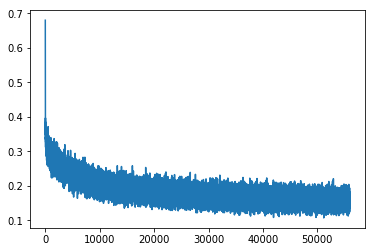

In [0]:
plt.plot(mbatch_cost)

In [0]:
#### Train set retrieve ####
train_XX_f=train_XX
train_yy_f=train_yy
print(train_yy_f[train_yy_f==1].shape)
print(train_yy_f[train_yy_f==0].shape)

(70810,)
(1215312,)


In [0]:
#### NN2 loss biased ####
seed(100)

#Train test idx
trainfoldx = torch.tensor(train_XX_f, dtype=torch.long).to(device)
trainfoldy = torch.tensor(train_yy_f, dtype=torch.float32).to(device)
x_val_fold = torch.tensor(test_X, dtype=torch.long).to(device)
y_val_fold = torch.tensor(test_y[:,np.newaxis], dtype=torch.float32).to(device)
print(trainfoldy[trainfoldy==1].shape)
print(trainfoldy[trainfoldy==0].shape)
print(y_val_fold[y_val_fold==1].shape)
print(y_val_fold[y_val_fold==0].shape)
# print(trainfoldy[0:5,])
# print(y_val_fold[0:5,])
#Our model
mbatch_cost = []
model = NeuralNet2()
model.to(device)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([(17.0)]).to(device))
optimizer = torch.optim.Adam(model.parameters(),lr=0.001, weight_decay=1e-8)
#Dataloader
train = torch.utils.data.TensorDataset(trainfoldx,trainfoldy)
valid = torch.utils.data.TensorDataset(x_val_fold, y_val_fold)

train_loader = torch.utils.data.DataLoader(train , batch_size=batch_size,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

for epoch in range(n_epochs):
    start = time.time()
    model.train()
    grand_loss = 0
    for  batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        #forward
        y_pred = model(x_batch)
        loss = loss_fn(torch.squeeze(y_pred), y_batch)

        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        mbatch_cost.append(loss.item())
        grand_loss += loss.item()/len(train_loader)
        if not batch_idx % 256:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
               %(epoch+1, n_epochs, batch_idx, len(train_loader), loss.item()))

                 #evaluation          
    model.eval()

    valid_pred = np.array(list())


    val_loss = 0

    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        val_loss += loss_fn(y_pred,y_batch).item()/len(valid_loader)
        valid_pred = np.append(valid_pred, np.array(torch.sigmoid(y_pred.cpu()))[:, 0])
    epoch_time=time.time()-start
    valid_acc = ((valid_pred>0.5).astype(int)==np.array(y_val_fold.squeeze().cpu())).sum()/len(y_val_fold)
    print('Epoch {}/{} \t train_loss={:.4f} \t test_loss={:.4f}\t test_accu={:.4f} \t time={:.2f}s'.format(epoch + 1, n_epochs, grand_loss, val_loss,valid_acc, epoch_time))

torch.Size([70810])
torch.Size([1215312])
torch.Size([10000])
torch.Size([10000])
Epoch: 001/023 | Batch 000/1256 | Loss: 1.2228
Epoch: 001/023 | Batch 256/1256 | Loss: 0.7291
Epoch: 001/023 | Batch 512/1256 | Loss: 0.6804
Epoch: 001/023 | Batch 768/1256 | Loss: 0.5051
Epoch: 001/023 | Batch 1024/1256 | Loss: 0.5618
Epoch 1/23 	 train_loss=0.6353 	 test_loss=10.1508	 test_accu=0.5000 	 time=85.57s
Epoch: 002/023 | Batch 000/1256 | Loss: 0.7217
Epoch: 002/023 | Batch 256/1256 | Loss: 0.7109
Epoch: 002/023 | Batch 512/1256 | Loss: 0.7309
Epoch: 002/023 | Batch 768/1256 | Loss: 0.8359
Epoch: 002/023 | Batch 1024/1256 | Loss: 0.5528
Epoch 2/23 	 train_loss=0.5897 	 test_loss=3.5950	 test_accu=0.4999 	 time=90.04s
Epoch: 003/023 | Batch 000/1256 | Loss: 0.6825
Epoch: 003/023 | Batch 256/1256 | Loss: 0.5546
Epoch: 003/023 | Batch 512/1256 | Loss: 0.5763
Epoch: 003/023 | Batch 768/1256 | Loss: 0.7653
Epoch: 003/023 | Batch 1024/1256 | Loss: 0.7301
Epoch 3/23 	 train_loss=0.5721 	 test_loss=5.

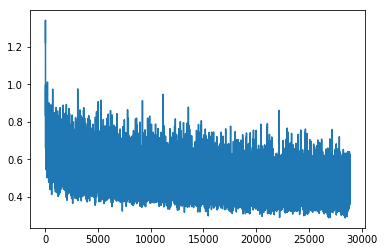

In [0]:
plt.plot(mbatch_cost)

In [0]:
del model